# Fitting a Line Using MCMC
By Griffin Hosseinzadeh (2019 April 17)  
Updated by Charlotte Mason (2020 August 28)  
Updated by Griffin Hosseinzadeh (2025 April 30)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import emcee
import corner

## Generate Some Fake Data
Choose a slope $m$, intercept $b$, and scatter $\sigma$, and generate $N$ random points using the `np.random` module. Plot the results to see what your data look like. Our goal is to recover the parameters defined here. (Hint: this section is identical to the previous notebook.)

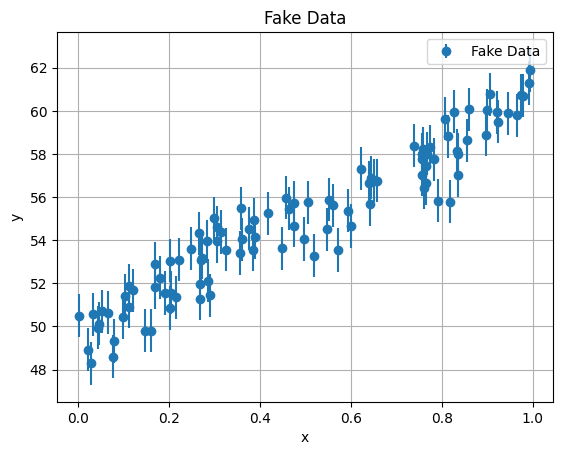

In [3]:
N = 100  # number of points
m = 10.  # slope
b = 50.  # intercept
sigma = 1.  # scatter

rng = np.random.default_rng()
x = rng.uniform(0, 1, N) # complete with random values between 0 and 1
y = m * x + b + rng.normal(0, sigma, N) # equation for a line PLUS random values from a Gaussian centered at 0 with standard deviation sigma
dy = np.full(N, sigma) # array of error bars for all the data (all sigma)

# plot your generated data with error bars
plt.errorbar(x, y, yerr=dy, fmt='o', label='Fake Data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Fake Data')
plt.legend()
plt.grid(True)
plt.show()

## Write Down the Posterior
Define functions that return the prior, the likelihood, and the posterior given a parameter vector `theta = [m, b]`. For computational accuracy (and convenience), we actually want to do this in log space. You can either use `np.log` (natural log) or `np.log10` (base-10 log). Regardless of the shape of your prior, it's good practice to limit the values of $m$ and $b$ to some reasonable range. (Hint: this section is identical to the previous notebook.)

In [4]:
m_min = 0.
m_max = 100.
b_min = 0.
b_max = 100.

def log_prior(theta):
    m, b = theta
    if m_min <= m <= m_max and b_min <= b <= b_max:
        return 0.0  # log(1), since it's uniform
    else:
        return -np.inf  # log(0), i.e., impossible

def log_likelihood(theta, x, y, dy):
    m, b = theta
    model = m * x + b
    residuals = y - model
    chi2 = np.sum((residuals / dy)**2)
    log_like = -0.5 * np.sum(np.log(2 * np.pi * dy**2)) - 0.5 * chi2
    return log_like

def log_posterior(theta, x, y, dy):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, dy)

## Set Up the Ensemble Sampler
This time we will use the `emcee` package that you imported above to sample the posterior probability distribution. Everything you need is contained within the `emcee.EnsembleSampler` class. Initialize this with 100 walkers and the `log_posterior` function you defined above. Don't forget that `log_posterior` takes additional arguments `x`, `y`, and `dy`. (Hint: check the documentation for `EnsembleSampler` for how to deal with this.)

Note, we will initialise the sampler in #1.5

In [5]:
n_walkers = 100
n_params = 2
args = (x, y, dy)

## Setup random initial guesses for the starting positions

You'll need to give initial guesses for each walker, which you can draw randomly from the prior. 

In [6]:
m_random = np.random.uniform(m_min, m_max, n_walkers)
b_random = np.random.uniform(b_min, b_max, n_walkers)
initial_guesses = np.column_stack((m_random, b_random))

## Initialize and run!

Initialize the `EnsembleSampler` object and then run it with the `run_mcmc` method. For now, 10000 steps is more than enough, and should run in less than a minute on your laptop. If this command takes too long, ask for help.

In [7]:
sampler = emcee.EnsembleSampler(n_walkers, n_params, log_posterior, args=args)

n_steps = 10000

sampler.run_mcmc(initial_guesses, n_steps, progress=True)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:26<00:00, 114.99it/s]


State([[10.62458028 49.86344465]
 [ 9.9977964  50.10819177]
 [10.72865568 49.73011159]
 [10.38180414 49.96111483]
 [10.90730873 49.80444197]
 [11.13710695 49.42130275]
 [11.42472962 49.32284101]
 [10.62171957 49.96204717]
 [10.14320507 49.95843521]
 [10.49993297 49.98145346]
 [10.43965635 50.02962828]
 [10.87867332 49.61099416]
 [10.96561879 49.61095308]
 [11.03000213 49.56468564]
 [10.61466527 49.80660759]
 [11.11410164 49.36764292]
 [10.21160369 49.92261903]
 [10.44532365 49.87102565]
 [10.83062069 49.63246957]
 [10.594992   49.8252196 ]
 [10.75624147 49.67501994]
 [10.22327822 50.06455471]
 [11.01502809 49.53519546]
 [10.53676725 49.95438779]
 [10.60981426 49.78847924]
 [10.46854455 49.84033793]
 [10.9419816  49.62818752]
 [10.15836458 50.21479304]
 [10.6670229  49.7845117 ]
 [10.23140953 50.07650519]
 [10.50944589 49.68832129]
 [11.09992029 49.67046844]
 [10.96865525 49.66049635]
 [10.82693149 49.55054415]
 [10.55401636 49.98455159]
 [10.67224525 49.83271342]
 [11.01425754 49.55362

## Plot the Results
First make a plot of the walker positions (value of each parameter) at each step. Write a function to do this, since you'll be using it a lot.

(100, 10000, 2)


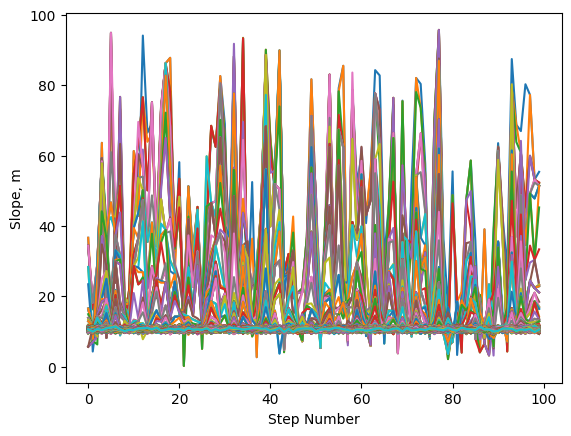

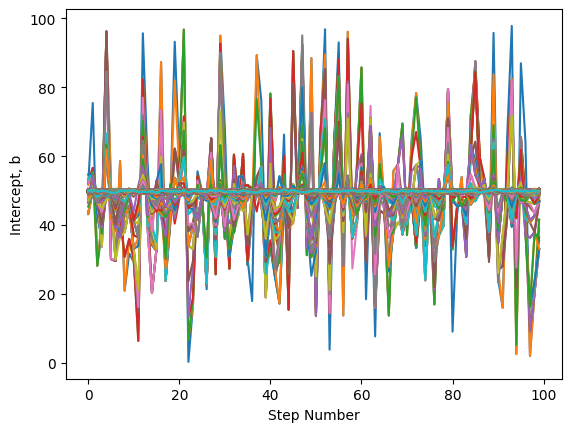

In [9]:
print(sampler.chain.shape)  # check that this has dimensions (n_walkers, n_steps, n_params)

def chain_plots(chain, **kwargs):
    """
    Plot the histories for each walker in sampler.chain
    
    Parameters
    ----------
    chain: ndarray
        3D array given by sampler.flatchain, with shape (n_walkers, n_steps, n_params)
    kwargs: `.Line2D` properties, optional
        All keyword arguments are passed to `pyplot.plot`
    """
    n_steps, n_walkers, n_params = chain.shape
    
    plt.figure()
    for i in range(n_walkers):
        plt.plot(chain[:, i, 0], **kwargs)
    plt.xlabel('Step Number')
    plt.ylabel('Slope, m')

    plt.figure()
    for i in range(n_walkers):
        plt.plot(chain[:, i, 1], **kwargs)
    plt.xlabel('Step Number')
    plt.ylabel('Intercept, b')

    plt.show
    
chain_plots(sampler.chain)

Each one of those colored lines is a walker. They started out at your initial guesses. What do you immediately notice?

Try making more useful plots by zooming in on the relevant parts. Hint: you can adjust line opacity in matplotlib with the `alpha` parameter.

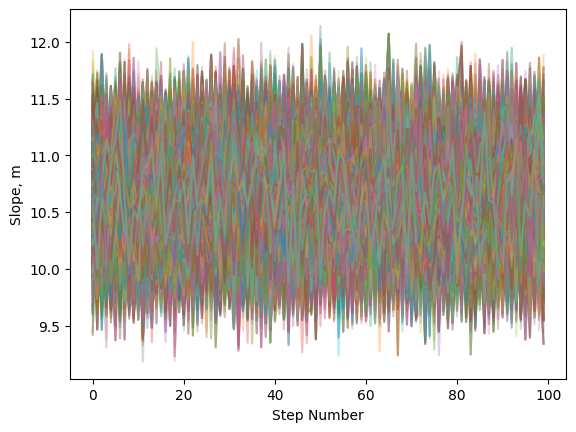

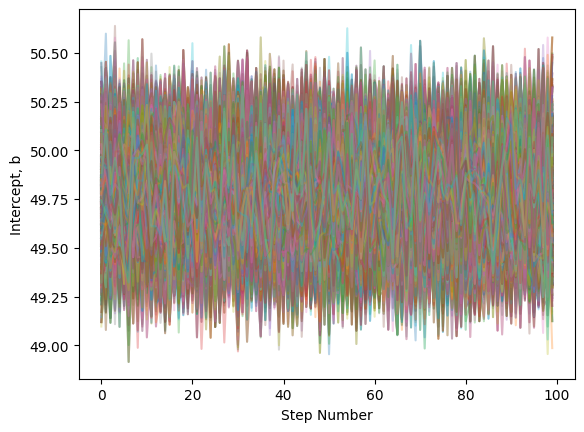

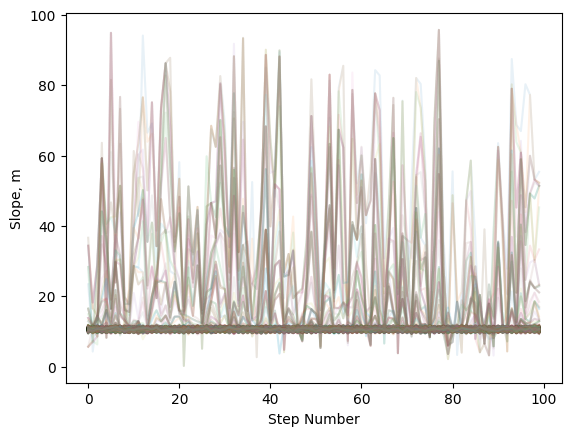

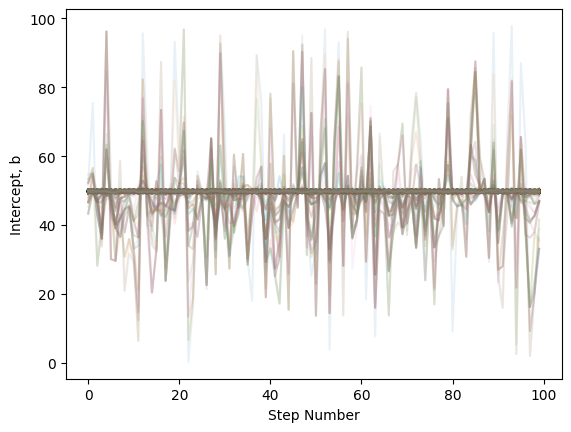

In [10]:
n_burn =  1000
chain_plots(sampler.chain[:, n_burn:, :], alpha=0.3)
chain_plots(sampler.chain, alpha=0.1)

Are your chains converged? How many steps did it take for this to happen? This is called the "burn-in" period. **From now on, only use the steps after the burn-in period.**

Now make a scatter plot of the two parameters, one point for each walker-step. Hint: `sampler.flatchain`.

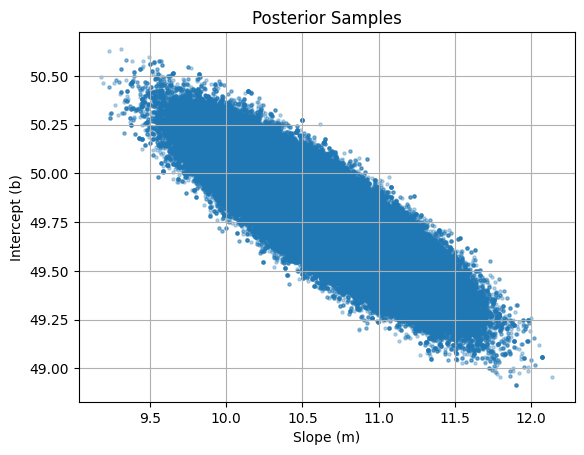

In [11]:
flat_samples = sampler.chain[:, n_burn:, :].reshape((-1, 2))

plt.figure()
plt.scatter(flat_samples[:, 0], flat_samples[:, 1], alpha=0.3, s=5)
plt.xlabel('Slope (m)')
plt.ylabel('Intercept (b)')
plt.title('Posterior Samples')
plt.grid(True)
plt.show()

How does this compare to the distribution you had in the previous notebook (assuming you used the same parameters)?

Now let's marginalize over each parameter. Given that we have walkers that are distributed according to the 2D posterior, think about how to calculate the marginalized posterior for each parameter.

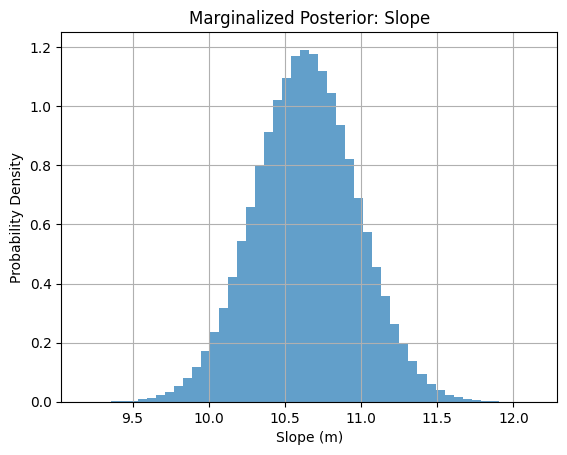

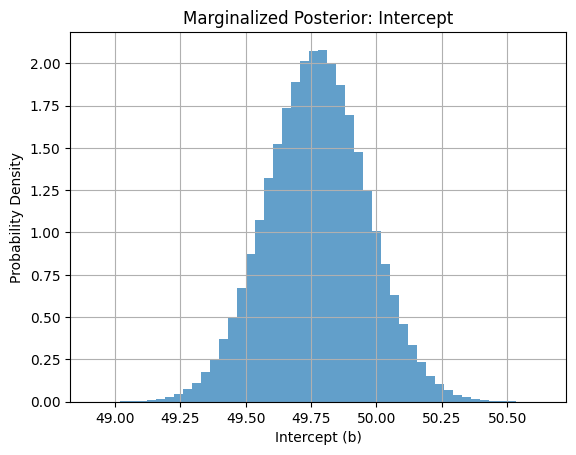

In [12]:
#slope
plt.figure()
plt.hist(flat_samples[:, 0], bins=50, density=True, alpha=0.7)
plt.xlabel("Slope (m)")
plt.ylabel("Probability Density")
plt.title("Marginalized Posterior: Slope")
plt.grid(True)

# intercept
plt.figure()
plt.hist(flat_samples[:, 1], bins=50, density=True, alpha=0.7)
plt.xlabel("Intercept (b)")
plt.ylabel("Probability Density")
plt.title("Marginalized Posterior: Intercept")
plt.grid(True)

plt.show()

Calculate the medians and the 68% ($1\sigma$) confidence intervals for each parameter. Check your answers against the centers and widths of the distributions you just plotted above. Do they look about right?

In [13]:
#slope
m_16, m_med, m_84 = np.percentile(flat_samples[:, 0], [16, 50, 84])
dm_lo = m_med - m_16
dm_hi = m_84 - m_med

# intercept
b_16, b_med, b_84 = np.percentile(flat_samples[:, 1], [16, 50, 84])
db_lo = b_med - b_16
db_hi = b_84 - b_med

# complete
print(f'$m = {m_med:.2f}_{{{dm_lo:+.2f}}}^{{{dm_hi:+.2f}}}$')

# complete
print(f'$b = {b_med:.2f}_{{{db_lo:+.2f}}}^{{{db_hi:+.2f}}}$')

$m = 10.64_{+0.33}^{+0.34}$
$b = 49.77_{+0.19}^{+0.19}$


There's an easy way to generate all these plots and summary statistics: `corner.corner`! Produce a corner plot with the true parameters labeled and the best-fit values (with error bars) printed on the plot. How close did we get to the parameters we used to generate the data?

In [ ]:
corner.corner(  # complete

## Take-Away Message
MCMC is a much more efficient way to sample the probability distribution because the walkers mostly stay in the highest-probability region. Plus it essentially gives you the marginalized posteriors for free, because the density of walkers matches the probability density.

## Other Things to Try
- Add a parameter for the intrinsic scatter and redo the MCMC fit.
- Try implementing Metropolis-Hastings algorithm yourself and see if you can get the same results as `emcee`.